Populating the interactive namespace from numpy and matplotlib


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


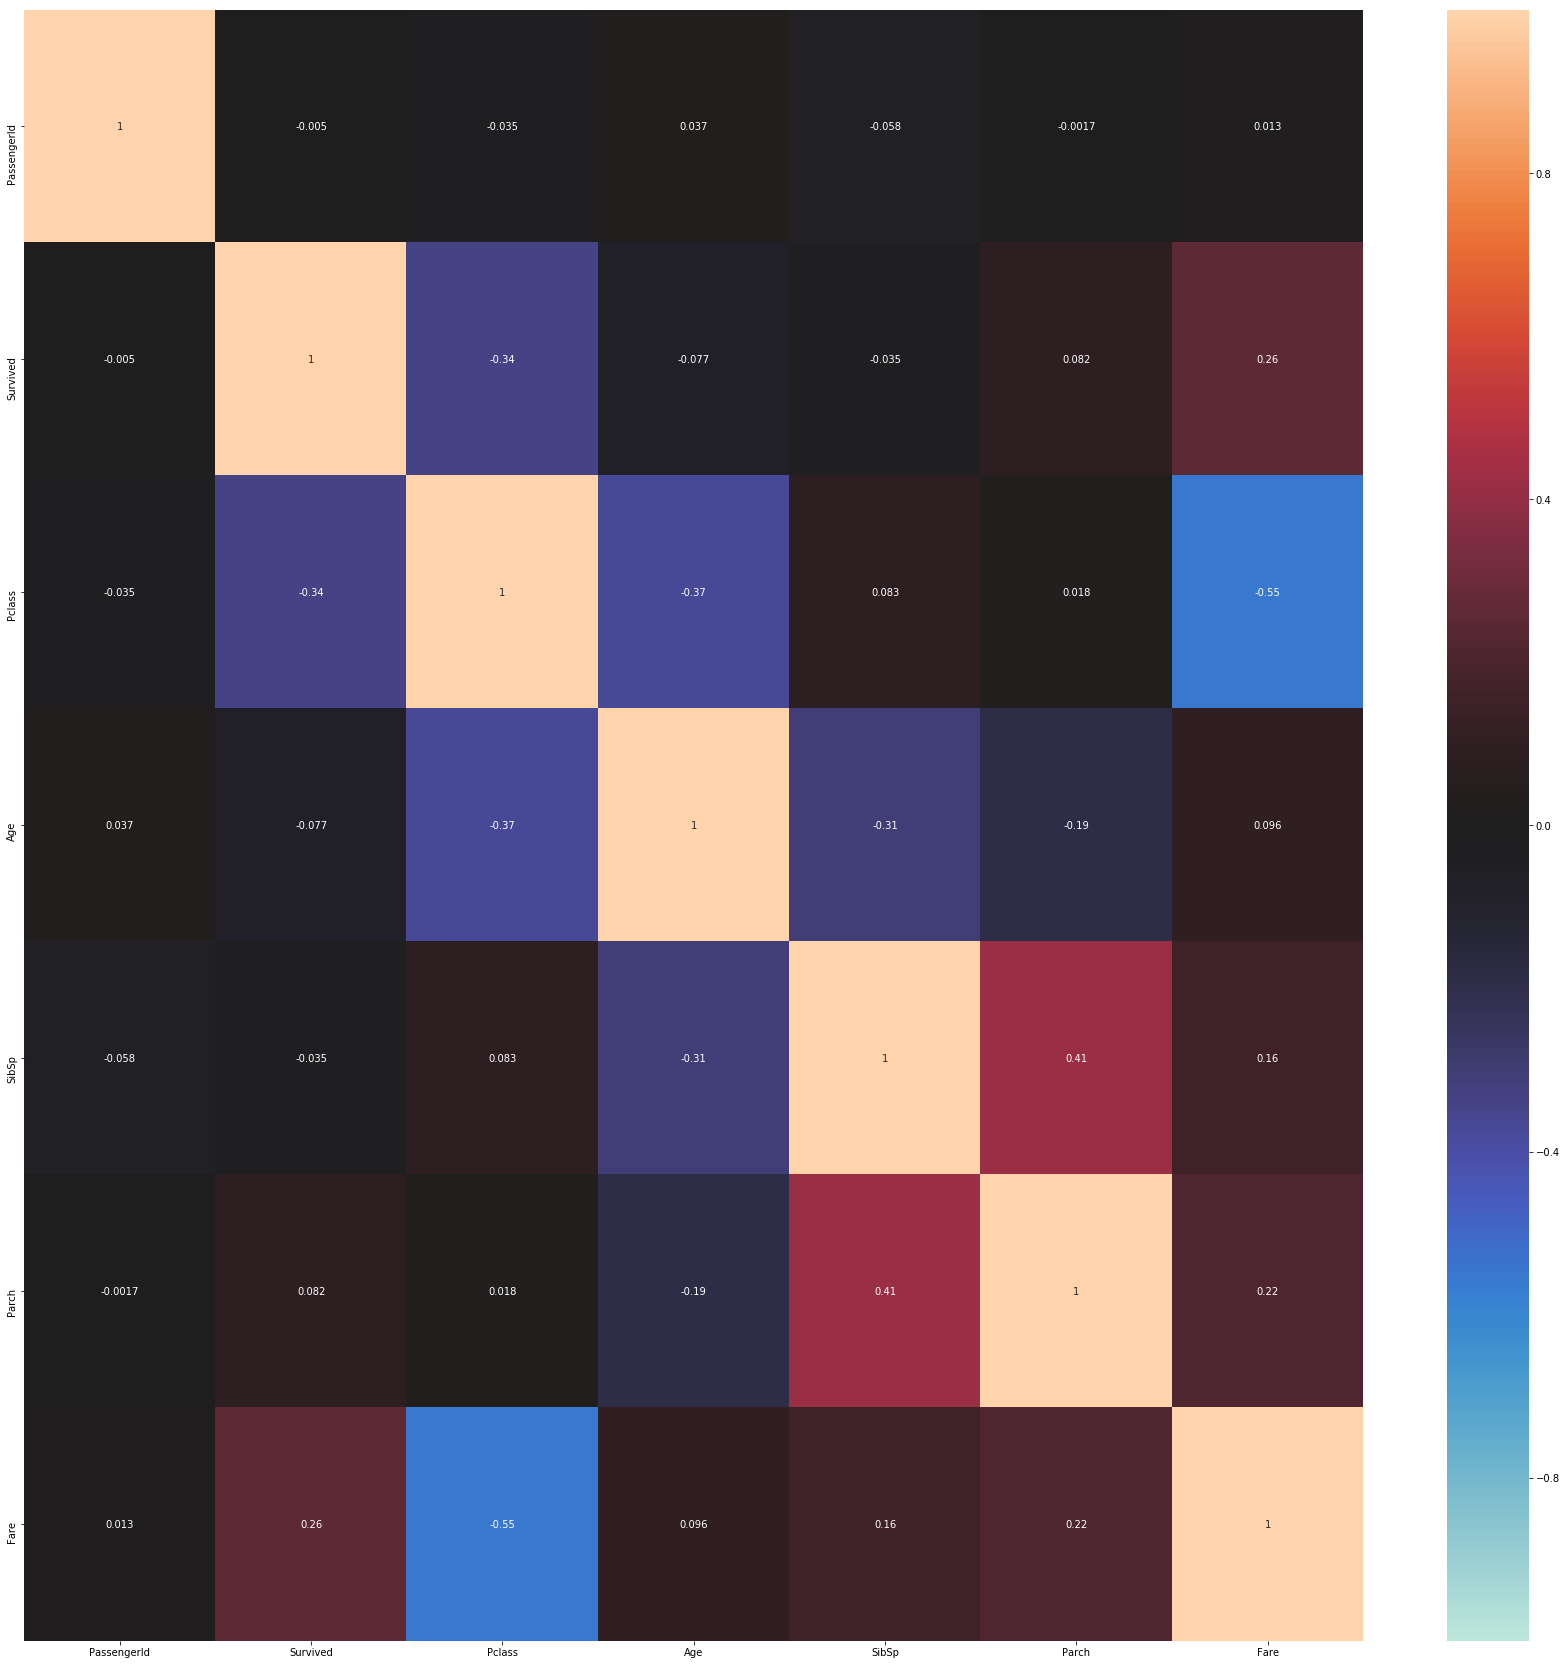

In [1]:
##############################前処理################################
%pylab inline --no-import-all
import pandas as pd
import numpy as np
import csv as csv
from sklearn.linear_model import LogisticRegression
import os
import mglearn
import matplotlib.pyplot as plt
from sklearn import cross_validation
import seaborn as sns

# Load training data
train_df = pd.read_csv("../input/train.csv", header=0)
test_df = pd.read_csv("../input/test.csv", header=0)
train_y=train_df["Survived"]
df_all = pd.concat([train_df.drop("Survived",axis=1), test_df]).drop("PassengerId",axis=1)

#Cabinは欠損が多すぎるので落とす
df_all=df_all.drop(["Cabin","Name"],axis=1)

#相関係数行列の可視化
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(train_df.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

#Ageの欠損埋め用データ取得(Sex_female Sex_maleごと)
age_mean=df_all.groupby(["Sex","Pclass"])["Age"].mean()

age_01=age_mean[0]
age_02=age_mean[1]
age_03=age_mean[2]
age_11=age_mean[3]
age_12=age_mean[4]
age_13=age_mean[5]

#Ageの欠損埋め
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="female") & (df_all['Pclass'] ==1) ,"Age"]=age_mean[0]
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="female") & (df_all['Pclass'] ==2) ,"Age"]=age_mean[1]
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="female") & (df_all['Pclass'] ==3) ,"Age"]=age_mean[2]
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="male") & (df_all['Pclass'] ==1) ,"Age"]=age_mean[3]
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="male") & (df_all['Pclass'] ==2) ,"Age"]=age_mean[4]
df_all.loc[(df_all['Age'].isnull()) & (df_all['Sex']=="male") & (df_all['Pclass'] ==3) ,"Age"]=age_mean[5]

#Embarkedの穴埋め
df_all.loc[df_all['Embarked'].isnull() ,"Embarked"]="S"

#Fareの穴埋め
fare_mean=df_all.groupby("Pclass")["Fare"].mean()
fare_01=int(fare_mean[1])
fare_02=int(fare_mean[2])
fare_03=int(fare_mean[2])

df_all.loc[(df_all['Fare'].isnull()) & (df_all['Pclass'] ==1) ,"Fare"]=fare_01
df_all.loc[(df_all['Fare'].isnull()) & (df_all['Pclass'] ==2) ,"Fare"]=fare_02
df_all.loc[(df_all['Fare'].isnull()) & (df_all['Pclass'] ==3) ,"Fare"]=fare_03

#カテゴリ変数をダミー変数化
df_all=pd.get_dummies(df_all)

#AgeとGenderの交差項の作成
df_all["fe_age"]=df_all["Sex_female"]*df_all["Age"]
df_all["ma_age"]=df_all["Sex_male"]*df_all["Age"]

#AgeとFareの交差項
df_all["fa_age"]=df_all["Fare"]*df_all["Age"]

#testとtrainの分割
train_x=df_all[:891]
test=df_all[891:]

In [3]:
##############################タイタニック(ロジスティック回帰)################################

#ロジスティック回帰
log_model = LogisticRegression(C=1)
log_model.fit(train_x,train_y)

#クロスバリデーションの結果
scores=cross_validation.cross_val_score(log_model,train_x,train_y,cv=10)
print("交差検証:n=10",np.mean(scores))

result=log_model.predict(test)

#  提出する
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": result
    })

交差検証:n=10 0.8182357280671887


In [4]:
##############################タイタニック(サポートベクターマシン)################################
from sklearn import svm
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler

# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
scaler.fit(train_x)
train_std = scaler.transform(train_x)
test_std = scaler.transform(test)

parameters = [{'kernel':['rbf'], 'C': [10**i for i in range(1,4)], 'gamma':[10**i for i in range(-4, 0)]}]

# グリッドサーチで優れたハイパーパラメータを探す
sv = grid_search.GridSearchCV(svm.SVC(), parameters, n_jobs = -1)
sv.fit(train_std,train_y)

#クロスバリデーションの結果
scores=cross_validation.cross_val_score(sv,train_std,train_y,cv=10)
print("交差検証:n=10",np.mean(scores))

result=sv.predict(test_std)

#  提出する
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": result
    })

C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


交差検証:n=10 0.8406208148904778


In [2]:
##############################タイタニック(ランダムフォレスト)################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

forest=RandomForestClassifier(random_state=2)

# 試行するパラメータを羅列する
params = {
    'max_depth': [3,5],
    'n_estimators'  : [10, 100, 200]
}

grid_forest = GridSearchCV(
    forest,
    param_grid=params,
    cv=10
    )

# グリッドサーチで優れたハイパーパラメータを探す
grid_forest.fit(train_x,train_y)

#クロスバリデーションの結果
scores=cross_validation.cross_val_score(grid_forest,train_x,train_y,cv=10)
print("交差検証:n=10",np.mean(scores))

result=grid_forest.predict(test)

#  提出する
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": result
    })

C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


交差検証:n=10 0.7979721371013506


In [8]:
#xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# xgboostモデルの作成
clf = xgb.XGBClassifier()

# グリッドサーチで優れたハイパーパラメータを探す
clf_cv = GridSearchCV(clf, {'max_depth': [4,6], 'n_estimators': [100,200] ,'min_child_weight':[2]},verbose=1)
clf_cv.fit(train_x,train_y)

#クロスバリデーションの結果
scores=cross_validation.cross_val_score(clf_cv,train_x,train_y,cv=10)
print("交差検証:n=10",np.mean(scores))

result=clf_cv.predict(test)

#  提出する
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": result
    })

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hirou\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

交差検証:n=10 0.8294339462036092
